<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week18_deeplearning_cv/ch18_5_fine_tuning_removed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch18_5 fine-tuning

참고자료: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

fine-tuning은 대량의 데이터에 대해서 이미 학습된 모델을 가져와 특정한 목적에 맞게끔 조금만 학습시키는 기법을 말합니다. CNN 모델의 경우, 이미지 넷으로 학습시킨 모델을 가져오게 되면 모델이 이미 이미지의 선이나 색상 등 low-level feature들을 학습한 상태이므로, 뒷 단의 레이어만 튜닝을 해주면 적은 데이터로도 성능이 뛰어난 모델을 얻을 수 있습니다. fine-tuning에도 여러 전략이 있습니다.

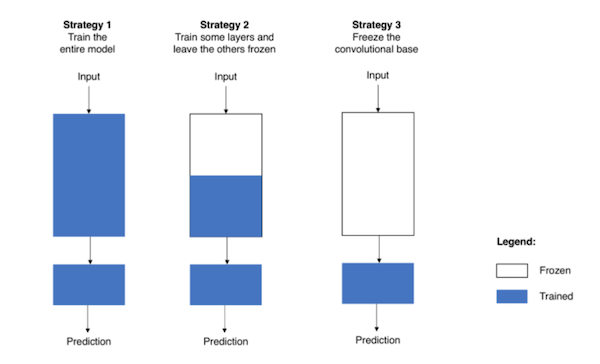

Strategy 1은 pretrained 모델을 가져와 전체 레이어들을 fine-tuning하는 방법입니다. 이는 데이터 셋이 충분히 많을때 유용하지만, 잘 사용하지 않는 방법입니다.

Strategy 2는 일부 Convolution Layer와 마지막에 Fully Connected Layer를 학습시키는 방식을 말합니다. 이는 pretrained model이 학습한 데이터 셋과 내 데이터 셋이 다를 경우 선택하는 방법입니다.

Strategy 3은 마지막 Fully Connected Layer만 학습시키는 방식을 말합니다. 보통 Fine-tuning이라고 하면 가장 먼저 이 방식을 적용해보고, 성능이 만족스럽지 않을 경우 뒷 단의 Convolution Layer를 조금씩 포함시켜서 다시 학습을 돌려봅니다.

## 사전 작업

### 디바이스 셋팅

###데이터 셋 준비

먼저 실습을 진행할 데이터 셋을 준비하겠습니다. 먼저 200장 남짓의 개미와 벌 이미지 데이터 셋이 주어졌고, 이 둘을 분류하는 모델을 만들어야 한다고 가정하겠습니다.

우리 실습에서는 이미지넷 데이터를 학습한 ResNet18 모델을 fine-tuning할 예정입니다. 입력 이미지의 전처리 로직은 해당 모델에서 가져오겠습니다.

(3, 224, 224) 크기로 입력 이미지를 Resize한 다음, 정규화를 통해 소수로 변환시켜 준 것을 확인할 수 있습니다.

### 모델 학습 코드 준비

In [ ]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [ ]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(val_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [ ]:
from collections import defaultdict


def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

In [ ]:
def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")
    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

## Finetuning

### 모델 준비

torch에 내장된 resnet18 모델을 불러와서 마지막 FC layer를 2진 분류에 맞게 교체해줍니다.

마지막 레이어가 1000개의 클래스로 분류해주도록 설정되어 있습니다. 이를 2개의 클래스만 분류하도록 교체해주겠습니다.

### Strategy 0. Train from scratch

첫 번째는 pretrained weight 없이 모델을 가져와서 처음부터 학습을 시켜보겠습니다.

### Strategy 1. Finetune entire model

이번에는 pretrained model을 가져와서 모델 전체를 fine-tuning해보겠습니다.

단순히 학습을 시작할 때 웨이트 값을 이미지 넷에 대해서 학습한 웨이트로 교체했을 뿐인데 모델의 성능이 훨씬 뛰어난 것을 확인할 수 있습니다. 바로 이것이 pretrained model을 사용하는 이유입니다.

### Strategy 2. Finetune some convolution layer

이번에는 두번째 전략을 시도해보겠습니다. 바로 앞단의 컨볼루션 레이어들은 pretrained weight로 고정하고, 뒷 단의 컨볼루션 레이어와 FC 레이어를 fine-tuning 시켜보겠습니다.

뒷단의 레이어만 학습이 가능하도록 설정하려면 먼저 전체 모델의 파라미터들을 freeze 해주고, 학습을 적용할 레이어만 freeze를 풀어주면 됩니다.

안정적으로 학습이 진행되면서 동시에 가장 뛰어난 성능을 보여줍니다.

### Strategy 3. Finetune only FC layer

마지막 fine-tuning 기법은 마지막 FC 레이어만 학습하는 방법입니다. 이는 전체 모델 weight는 고정한 채로 FC layer만 새로 교체한 뒤에 학습을 해주면 됩니다.

마지막 FC 레이어만 학습을 시키니 학습이 빠르고 안정적으로 진행됩니다. 여기에 성능까지 가장 뛰어난 모습을 보여줍니다. 이처럼 데이터가 부족한 상황에서는 pretrained model의 weight를 고정한 채로 마지막 레이어만 fine-tuning하는 기법이 상당히 유용합니다.

## 모델 저장하기

학습을 완료한 모델은 따로 저장해보겠습니다. pytorch 모델 확장자는 보통 pth를 사용합니다.

## 정리

이번 챕터에서는 pretrained model을 가져와서 우리 데이터 셋에 맞게끔 fine-tuning하는 기법에 대해서 알아보았습니다. fine-tuning을 하게 될 경우, 빠르고 안정적으로 모델 학습을 할 수 있을 뿐만아니라 성능까지 뛰어났습니다. 실제로 fine-tuning은 실무에서 많이 활용되니, 사용법을 잘 익혀주시기 바랍니다.